In [19]:
import os 
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
sns.set_theme(style="dark")

In [ ]:
move_labels = False
convert_to_jpg = False

In [2]:
train_labels = pd.read_csv("data/train_labels.csv")
print(f'Number of training examples: {train_labels.shape[0]}')

Number of training examples: 220025


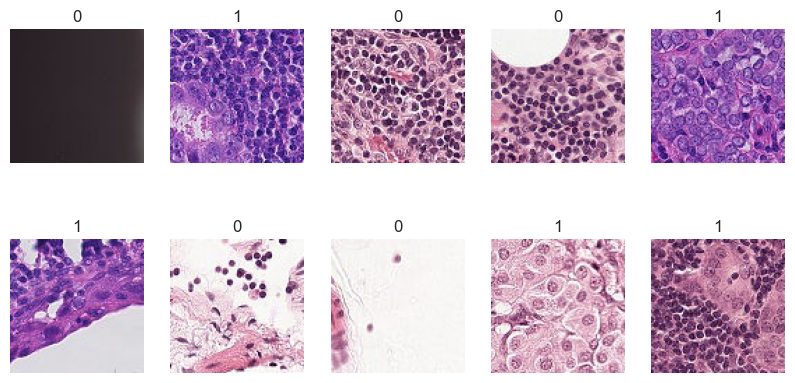

In [3]:
train_labels_sample = train_labels.sample(10, random_state=42)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for ax, row in zip(axes.ravel(), train_labels_sample.itertuples()):
    image = plt.imread("data/train/" + row.id + ".tif")
    ax.imshow(image)
    ax.set_title(row.label)
    ax.set_axis_off()
    


In [4]:
print(f'Dimensions of image: {image.shape}')
print(f'Number of channels: {image.shape[2]}')
print(f'Ranges of each channel: {np.min(image), np.max(image)}')

Dimensions of image: (96, 96, 3)
Number of channels: 3
Ranges of each channel: (np.uint8(0), np.uint8(255))


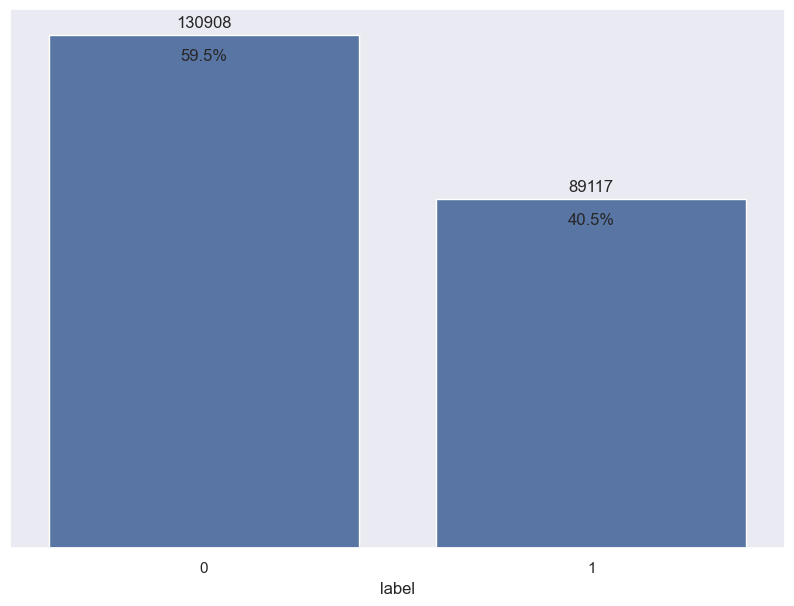

In [5]:
plt.figure(figsize=(10, 7))
bar = sns.countplot(data=train_labels, x="label")
for p in bar.patches:
    bar.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    # annote percentage
    bar.annotate(format(p.get_height() / train_labels.shape[0], '.1%'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, -15), textcoords='offset points')
bar.set(xlabel="label")
plt.ylabel("")
plt.yticks([]);

We have an imbalanced dataset so we need to be careful when splitting the data.

In [6]:
x_train, x_val, y_train, y_val = train_test_split(train_labels["id"], train_labels["label"], test_size=0.2, random_state=42, stratify=train_labels["label"])
print(f'Number of training examples: {x_train.shape[0]}')
print(f'Number of validation examples: {x_val.shape[0]}')

Number of training examples: 176020
Number of validation examples: 44005


In [20]:
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/val", exist_ok=True)
os.makedirs("data/train/0", exist_ok=True)
os.makedirs("data/train/1", exist_ok=True)
os.makedirs("data/val/0", exist_ok=True)
os.makedirs("data/val/1", exist_ok=True)

if move_labels:
    for id, label in zip(x_train, y_train):
        shutil.move(f"data/train/{id}.tif", f"data/train/{label}/{id}.tif")

    for id, label in zip(x_val, y_val):
        shutil.move(f"data/train/{id}.tif", f"data/val/{label}/{id}.tif")
        
if convert_to_jpg:
    for id, label in zip(x_train, y_train):
        img = Image.open(f"data/train/{label}/{id}.tif")
        img.save(f"data/train/{label}/{id}.jpg")
        os.remove(f"data/train/{label}/{id}.tif")

    for id, label in zip(x_val, y_val):
        img = Image.open(f"data/val/{label}/{id}.tif")
        img.save(f"data/val/{label}/{id}.jpg")
        os.remove(f"data/val/{label}/{id}.tif")

In [21]:
traning_set = keras.utils.image_dataset_from_directory(
    "data/train/",
    labels='inferred',
    class_names=["0", "1"],
    color_mode="rgb",
    batch_size=32,
    image_size=(96, 96),
    shuffle=True,
    seed=42
)


Found 176020 files belonging to 2 classes.


In [22]:
validation_set = keras.utils.image_dataset_from_directory(
    "data/val/",
    labels='inferred',
    class_names=["0", "1"],
    color_mode="rgb",
    batch_size=32,
    image_size=(96, 96),
    shuffle=True,
    seed=42
)

Found 44005 files belonging to 2 classes.


We need to standardize the pixel values to be between 0 and 1.